[INFO] Using: /Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_daily/glass/v60/Data/LAI/LAI.1440.720.2020.nc
[RAW] min=-9999.0 max=60.0 dtype=float64 _FillValue=-9999.0 scale_factor=0.1 add_offset=0
[RAW→SCALED] finite=250538 of 1036800, scaled_min=0.0, scaled_max=6.0


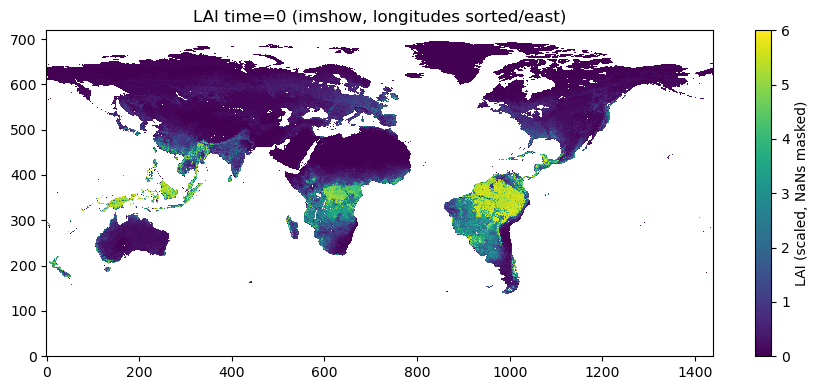

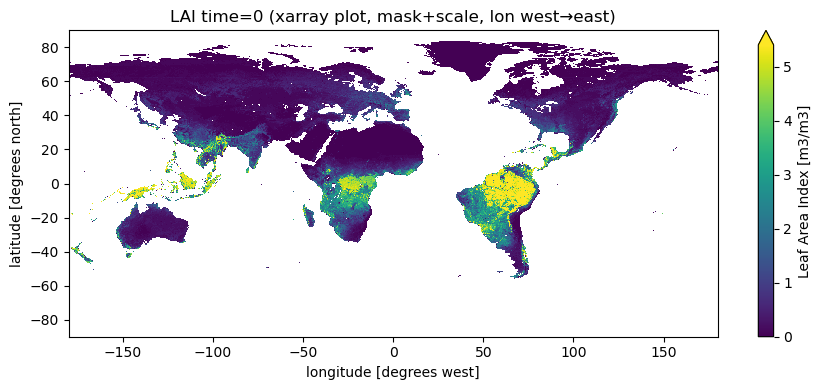

In [8]:
%matplotlib inline
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# point to the file you ncdumped
nc_path = Path("/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_daily/glass/v60/Data/LAI/LAI.1440.720.2020.nc")
print(f"[INFO] Using: {nc_path}")

# 1) Open once WITHOUT masking/scaling to see raw values
ds_raw = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=False)
da_raw = ds_raw["LAI"].isel(time=0)

raw_min = float(np.nanmin(da_raw.values))
raw_max = float(np.nanmax(da_raw.values))
print(f"[RAW] min={raw_min} max={raw_max} dtype={da_raw.dtype} _FillValue={da_raw.attrs.get('_FillValue')} "
      f"scale_factor={da_raw.attrs.get('scale_factor')} add_offset={da_raw.attrs.get('add_offset')}")

# Manually apply mask & scale
fv = da_raw.attrs.get("_FillValue", -9999.0)
mask = np.isclose(da_raw.values, fv)
data = da_raw.values.astype("float32", copy=False)
sf = da_raw.attrs.get("scale_factor", 1.0) or 1.0
ao = da_raw.attrs.get("add_offset", 0.0) or 0.0
data = data * np.float32(sf) + np.float32(ao)
data = np.where(mask, np.nan, data)

nfinite = np.isfinite(data).sum()
print(f"[RAW→SCALED] finite={int(nfinite)} of {data.size}, scaled_min={np.nanmin(data)}, scaled_max={np.nanmax(data)}")

# 2) Get coords (they're named latitude/longitude here)
lat = ds_raw["latitude"].values
lon = ds_raw["longitude"].values

# Convert "degrees west" to degrees east, sort ascending (optional but nice for plotting)
# If your longitudes are already east-like, you can skip the sign flip.
lon_e = -lon  # "degrees west" -> east
order = np.argsort(lon_e)
lon_e = lon_e[order]
data_sorted = data[:, order]  # reorder X dimension

# 3) Plot with imshow (doesn't depend on CF metadata), then with xarray plot
plt.figure(figsize=(9,4))
plt.imshow(data_sorted, origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(label="LAI (scaled, NaNs masked)")
plt.title("LAI time=0 (imshow, longitudes sorted/east)")
plt.tight_layout()
plt.show()

# 4) Now try xarray’s plot with masking/scaling ENABLED (what you initially expected)
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)
da = ds["LAI"].isel(time=0)

# Rename coords so xarray knows they’re geospatial and sort latitude ascending
ds2 = ds.rename({"latitude":"lat","longitude":"lon"})
ds2 = ds2.assign_coords(lon=-ds2["lon"]).sortby("lon")  # west->east, sort
if (np.diff(ds2["lat"].values) < 0).any():
    ds2 = ds2.sortby("lat")

plt.figure(figsize=(9,4))
ds2["LAI"].isel(time=0).plot(robust=True)  # robust to ignore outliers in color scaling
plt.title("LAI time=0 (xarray plot, mask+scale, lon west→east)")
plt.tight_layout()
plt.show()

ds_raw.close(); ds.close()

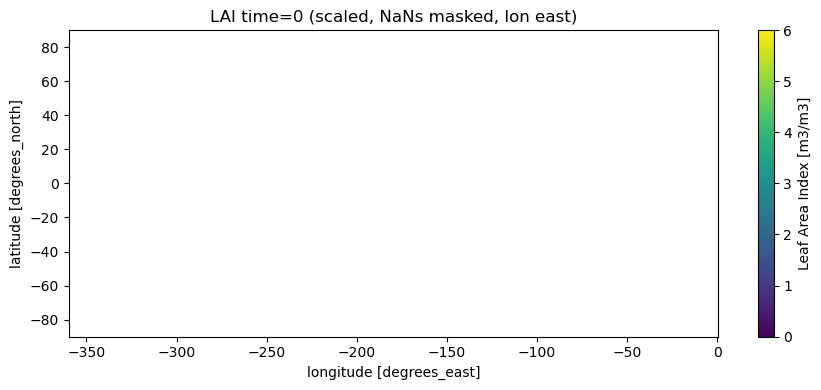

finite fraction: 0.0


In [ ]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

regrid_path
rename_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/modis_lai/data/4.rename_vars/LAI.1440.720.2000.nc")

# open with mask+scale so -9999 -> NaN and scale_factor=0.1 applied
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)

# convert "degrees west" to east-longitudes and sort; also make latitude ascending
ds = ds.assign_coords(lon=-ds["lon"]).sortby("lon")
if (np.diff(ds["lat"].values) < 0).any():
    ds = ds.sortby("lat")

da0 = ds["modis_lai"].isel(time=0)

plt.figure(figsize=(9,4))
da0.plot(vmin=0, vmax=6)   # <- force sensible scale for LAI
plt.title("LAI time=0 (scaled, NaNs masked, lon east)")
plt.tight_layout()
plt.show()

print("finite fraction:", float(np.isfinite(da0.values).mean()))
ds.close()

In [34]:
ds = xr.open_zarr("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/predictions/full_run_with_mrso/no_carry/zarr/S3/annual.zarr", decode_times=False)

da = ds["cLitter"].isel(time=0)

lon = ds["lon"].values
lat = ds["lat"].values

print(lon, lat)



[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5  79.   79.5  80.   80.5  81.   81.5  8

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

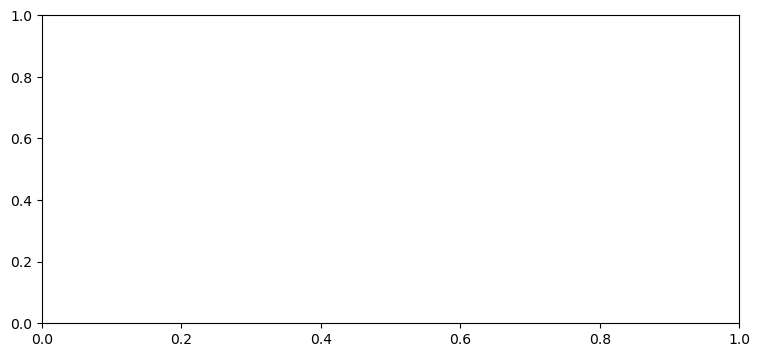

In [28]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

nc_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/predictions/full_run_with_mrso/no_carry/netcdf/S3/S3_cLitter.nc")
ds  = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False)

# pick variable & first timestep
da0 = ds["cLitter"].isel(time=1)

plt.figure(figsize=(9,4))
da0.plot()                       # ← this actually draws the data
plt.title("cLitter @ time=1")
plt.tight_layout()
plt.show()

ds.close()

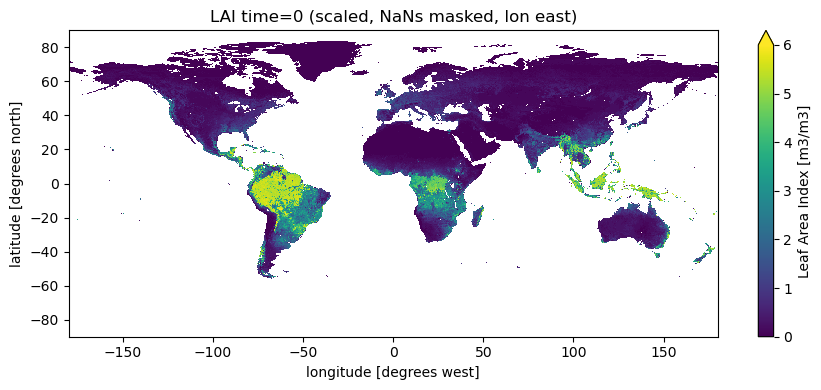

finite fraction: 0.24166473765432098


In [2]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

nc_path = Path("/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_daily/glass/v60/Data/LAI/LAI.1440.720.2018.nc")

# open with mask+scale so -9999 -> NaN and scale_factor=0.1 applied
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)
ds = ds.rename({"latitude":"lat","longitude":"lon"})

da0 = ds["LAI"].isel(time=0)

plt.figure(figsize=(9,4))
da0.plot(vmin=0, vmax=6)   # <- force sensible scale for LAI
plt.title("LAI time=0 (scaled, NaNs masked, lon east)")
plt.tight_layout()
plt.show()

print("finite fraction:", float(np.isfinite(da0.values).mean()))
ds.close()

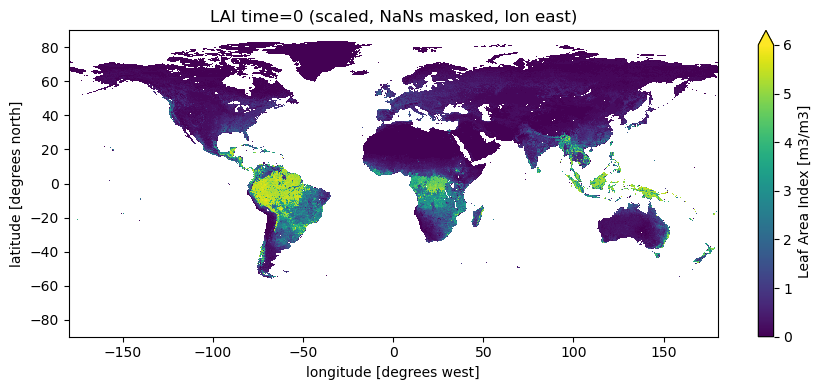

finite fraction: 0.24159529320987655


In [3]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

nc_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/modis_lai/data/1.trimmed/LAI.1440.720.2008.nc")

# open with mask+scale so -9999 -> NaN and scale_factor=0.1 applied
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)
ds = ds.rename({"latitude":"lat","longitude":"lon"})

da0 = ds["LAI"].isel(time=0)

plt.figure(figsize=(9,4))
da0.plot(vmin=0, vmax=6)   # <- force sensible scale for LAI
plt.title("LAI time=0 (scaled, NaNs masked, lon east)")
plt.tight_layout()
plt.show()

print("finite fraction:", float(np.isfinite(da0.values).mean()))
ds.close()

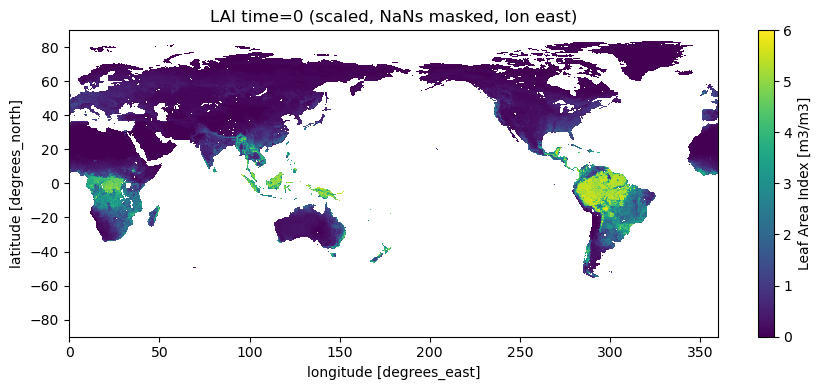

finite fraction: 0.2287847222222222


In [6]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

nc_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/modis_lai/data/3.chunk/LAI.1440.720.2008.nc")

# open with mask+scale so -9999 -> NaN and scale_factor=0.1 applied
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)

da0 = ds["LAI"].isel(time=0)

plt.figure(figsize=(9,4))
da0.plot(vmin=0, vmax=6)   # <- force sensible scale for LAI
plt.title("LAI time=0 (scaled, NaNs masked, lon east)")
plt.tight_layout()
plt.show()

print("finite fraction:", float(np.isfinite(da0.values).mean()))
ds.close()

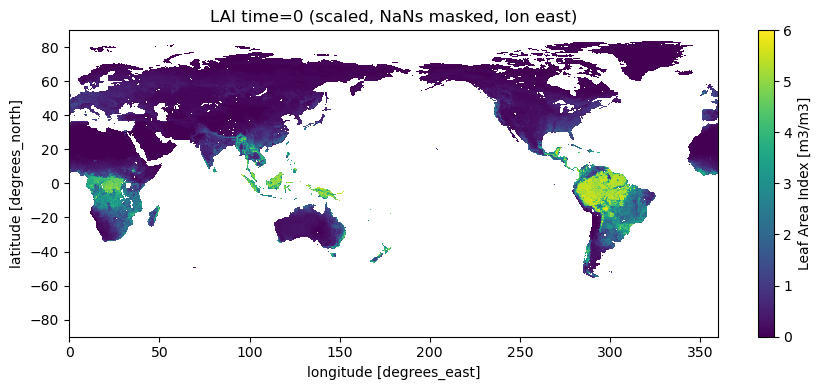

finite fraction: 0.2287847222222222


In [8]:
%matplotlib inline
import numpy as np, xarray as xr, matplotlib.pyplot as plt
from pathlib import Path

nc_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/modis_lai/data/4.rename_vars/LAI.1440.720.2008.nc")

# open with mask+scale so -9999 -> NaN and scale_factor=0.1 applied
ds = xr.open_dataset(nc_path, engine="netcdf4", decode_times=False, mask_and_scale=True)

da0 = ds["modis_lai"].isel(time=0)

plt.figure(figsize=(9,4))
da0.plot(vmin=0, vmax=6)   # <- force sensible scale for LAI
plt.title("LAI time=0 (scaled, NaNs masked, lon east)")
plt.tight_layout()
plt.show()

print("finite fraction:", float(np.isfinite(da0.values).mean()))
ds.close()

In [ ]:
import netCDF4 as nc
from pathlib import Path

# --- Path to your NetCDF file ---
path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/DATA/nbp/ENSMEAN/ENSMEAN_S3_nbp.nc")

# --- Open file in append mode ---
with nc.Dataset(path, "a") as ds:
    var = ds.variables["nbp"]
    var.setncattr("units", "kg m-2 s-1")
    var.setncattr("long_name", "Net Biome Productivity")
    var.setncattr("standard_name", "net_biome_productivity_of_biomass_expressed_as_carbon_mass_flux")
    print(f"Updated units for {path.name}: {var.units}")

Updated units for ENSMEAN_S3_nbp.nc: kg m-2 s-1


In [2]:
import netCDF4 as nc
from pathlib import Path

# --- Parent directory to scan ---
parent = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS")

for f in parent.rglob("*.nc"):
    try:
        with nc.Dataset(f, "a") as ds:
            for varname in ds.variables:
                if varname in ("nbp", "gpp"):
                    var = ds.variables[varname]
                    var.setncattr("units", "kg m-2 s-1")
                    long_name = "Net Biome Productivity" if varname == "nbp" else "Gross Primary Production"
                    std_name = (
                        "net_biome_productivity_of_biomass_expressed_as_carbon_mass_flux"
                        if varname == "nbp"
                        else "gross_primary_productivity_of_biomass_expressed_as_carbon_mass_flux"
                    )
                    var.setncattr("long_name", long_name)
                    var.setncattr("standard_name", std_name)
                    print(f"✅ Updated {varname} in {f}")
    except Exception as e:
        print(f"⚠️ Skipped {f} ({e})")

✅ Updated gpp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/CLM/CLM5.0_S3_gpp.nc
✅ Updated nbp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/CLM/CLM5.0_S3_nbp.nc
✅ Updated nbp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/ORCHIDEE/ORCHIDEE_S3_nbp.nc
✅ Updated gpp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/ORCHIDEE/ORCHIDEE_S3_gpp.nc
✅ Updated nbp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/JSBACH/JSBACH_S3_nbp.nc
✅ Updated gpp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/analysis/ilamb/tutorial/my_attempt/MODELS/JSBACH/JSBACH_S3_gpp.nc
✅ Updated nbp in /Net/Groups/BGI/people/ecathain/TRENDY_Emulat